## SESSION 3: PRACTICAL CONSIDERATIONS IN CNN

SO Basics of Neural Networks 2023 school at the IAA-CSIC. Nov 2023.  
Eduardo Sánchez Karhunen (fesanchez@us.es)  
University of Seville. Spain. Dept. of CS and AI

### 1. Introduction

In the previous sessions we have plotted the evolution of loss and accuracy in train and validation datasets during the training process.

<br>

**Galaxy10:** using MLP

![picture](https://drive.google.com/uc?id=17CyVFwe2Cpc48AveWQFrpNRl7gyx8pTX)

**Galaxy10:** using CNNs

![picture](https://drive.google.com/uc?id=1AB1nuy1wk1qhC4OSIQuuYnOW8c3U5mVq)

In both architectures, after a certain amount of epochs:
* the training loss continues its reduction.
* on the contrary, the validation loss stops its reduction and starts to grow again.

### 2. OVERFITTING

When this phenomenon appears in a model, it is an indication of the presence of, the so called, overfitting. **The model performs well on the training data, but it does not generalizes well**. This model generalization capacity is determined computing its accuracy on a dataset that has not been used for training = the validation dataset.

<br>

![picture](https://drive.google.com/uc?id=1pc08rrN5a7ti8D4i1WEqTCaWiYWRZNUc)

Overfitting appears due to an imbalance between:
* The amount of data for training
* The model complexity. In other words, the number of parameters.

When a model has a large number of parameters it makes the model so powerful that it is able to:
* Memorize the data and noise.
* Even the minimum details and non-sense relations.

Neural Networks are extremely powerful because of the high number of parameters. Hence, overfitting must be always considered. There are multiple techniques to prevent overfitting in NN:
* Early stopping
* Drop-out
* Data Augmentation




#### 3. EARLY STOPPING

It does not seem reasonable to continue training beyond the epoch in which overfitting appears. A posteriori, it is easy to locate this moment. But it is more challenging to detect its appearance during training. **Early Stopping** is the most commonly used technique.

The idea es:

1. **Monitor validation error** after each epoch.
2. Store the **epoch with the minimum loss error**.
3. If the validation error becomes worse than the minimum value stored, a** counter is started**.

> It has sense not to stop immediately the training when the error gets worse becayse training processes can present an oscillatory behaviour during gradient descent. Commonly, in posterior epochs error can again drop again.

4. After the counter is started, we have to decide **how many epochs we are willing to endure an error worsening**. Hoping that in later epochs, a reduction of loss appears again.

> Patience: it is a parameter of the early stopping. Typical values are: 3, 5, ...

5. If the patience value **is reached, training is stopped**.
6. If before the patience value is reached, the loss is reduced again under the minimum value stored. Go to step 2).

Once the patience is reached, we can restore the model which produced the minimum loss error obtained during the training process.

In practice:
* EPOCH is fixed to a large value, knowing that Early Stopping is going to stop the process when overfitting appears.
* In Tensorflow Early stopping is implmeneted via  _callbacks_. Training process is an opaque module that in this course we do not know how to change. But using callbacks as argument in the `.fit` method we can perform operations within the training process and stop it once patience value has been reached.
for that purpose, a concrete type of callback is considered: EarlyStopping callback.

#### 4. DATA-AUGMENTATION

If overfitting is the unwanted capacity of the model to memorize the training dataset. One possibility we have is to increase our training dataset. Typically, all data at our disposal has been used for training & validation. It is not possible to gather more data. There is another possibility: **Data augmentation**. This technique builds a new synthetic dataset from our original dataset introducing random perturbations (ensuring that the class labels are not changes). If the networks receives constantly modified versions of the data, the network is able to learn more robust representations of the data: learns to generalize better.

Different transformations can be applied:

  > Rotation  
  > Flip, horizontal and/or vertical  
  > Brightness adjustment
  > Many more ...

<br>

![picture](https://drive.google.com/uc?id=1rlKJHuocG7LdfzVMksb8vabQMgpjE3NU)



* Insert slight "difficulties" during the training process.



2.   Dropout: consiste en "apagar" neuronas de la capa a la que le apliquemos el dropout. El número de neuronas que apagamos viene dado por el parámetro: drop rate, que suele estar en el orden del 50% para CNNs. Las neuronas que son apagadas, cambian de un minibatch al siguiente.

Por ultimo indicar que el proceso de Data Augmentation se realiza siempre sobre el dataset de train y nunca sobre el de validacion. Estas transformaciones asociadas al Data Augmentation se indican directamente al crear el DataGenerator.

### DOGS AND CATS CLASSIFICATION

In our first session the fashion-MNIST problem was tackled. Accuracies aprox 90% were obtained with a single convolutional step. Hence, this problem is "easy" to be solved using CNNs. Let's consider the more challenging problem: dogs & cats image classification.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import img_to_array, load_img
import tensorflow as tf
import pandas as pd
import numpy as np

### 1. Data Loading

The original dataset is in Kaggle, but a 2K images subset can be directly downloaded from Google.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-11-12 23:31:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  22.5MB/s    in 2.9s    

2023-11-12 23:31:41 (22.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In image classification problems, depending on the image dataset size there are two possible situations:
* Datasets of a reduced size: the whole dataset is loaded in memory.
* It is not possible to load in memory the whole dataset. In this case, images must be read from disk during the training process.

Once unzipped the dogs&cats zipfile, a typical classification problem folder tree is built:
* One folder for train and validation.
* Images are splitted into different subfolder, one for each class.   

/tmp/cats_and_dogs_filtered
  
|---- Train  
> | ------- cats  
> | ------- dogs

|---- Valid  
> | ------- cats  
> | ------- dogs

These folder simply contain the image files, e.g.:

'cat.182.jpg', 'cat.701.jpg', 'cat.397.jpg', 'cat.551.jpg', 'cat.995.jpg'

Later we will need to make reference to these directories. Let's create variables containing these paths.

Note: if you are not running this notebook in google colab, you must change this vars path info.

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

This dataset contaisn 2K training images and 1K valid images splitted into two balanced classes.

In [ ]:
print(f"training cat: {len(os.listdir(train_cats_dir))}, training dog: {len(os.listdir(train_dogs_dir))}")
print(f"validation cat: {len(os.listdir(validation_cats_dir))}, validation_cat: {len(os.listdir(validation_dogs_dir))}")

training cat: 1000, training dog: 1000
validation cat: 500, validation_cat: 500


### 2. Dataset visualization

8 cats and 8 dogs images are shown:

In [ ]:
train_cat_files = os.listdir(train_cats_dir)
train_dog_files = os.listdir(train_dogs_dir)

In [ ]:
next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_files[0:8]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_files[0:8]]

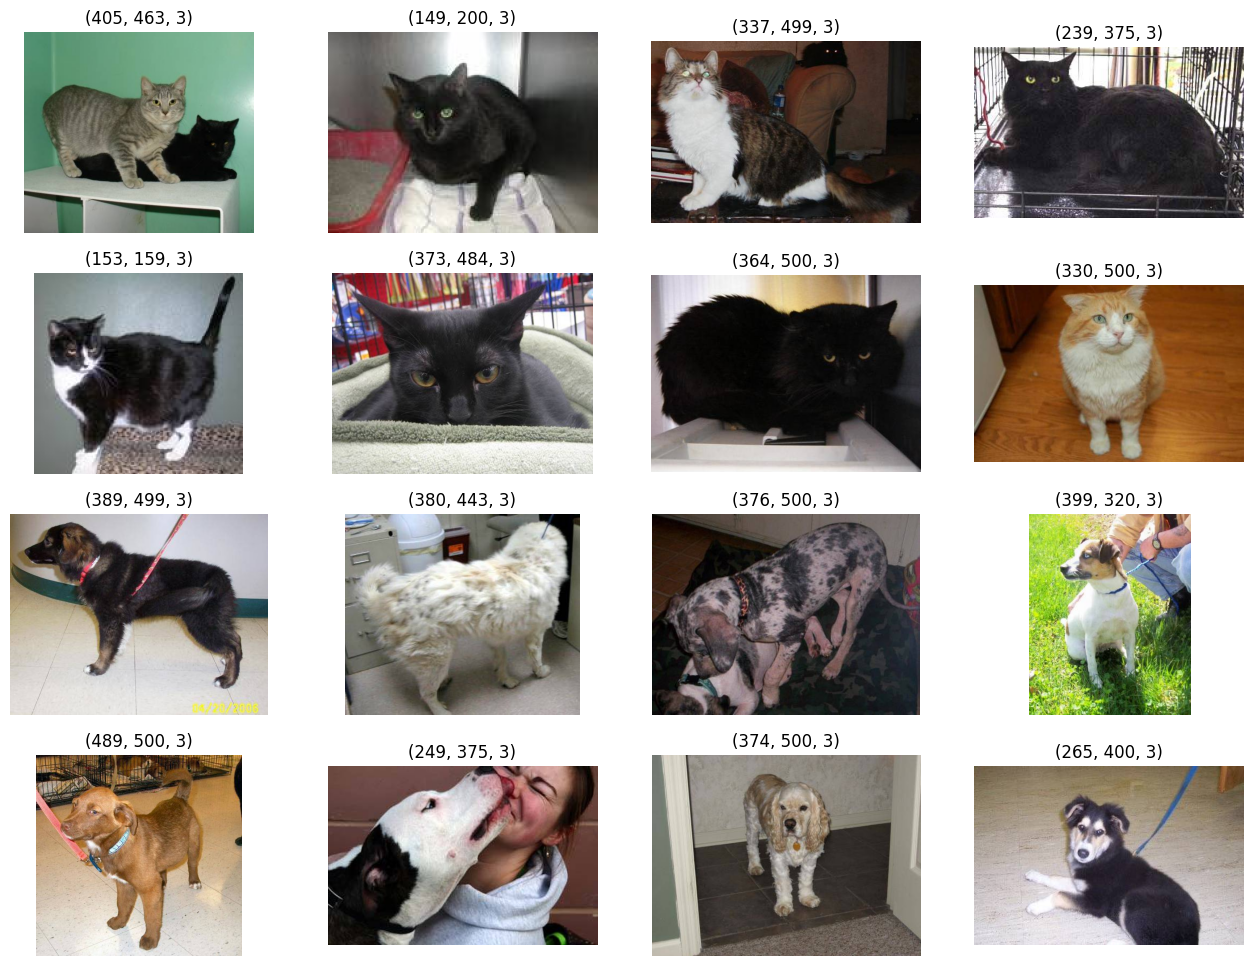

In [ ]:
plt.figure(figsize=(16,12))
for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.title(img.shape)
  plt.imshow(img)

Some interesting facts about this dataset:
* Images can have different sizes.
* The element to classify is not isolated in a white background. There can be elements that can impact into the decision. e.g. the leashes and necklaces.

But the dataset has some non-realistic elements:
* Animals appear centered in the image.
* Animals occupy the vast majority of the image.

### 3. Convolutional model


Let's consider a three stage CNN with the following parameters:

1.   16 kernels -> 32 kernels -> 64 kernels
2.   Kernel size = 3x3.
3.   Default stride and padding (stride=1, no-padding).
4.   Pooling 2x2 with default stride (stride=2).
5.   Limit image size to 150 x 150.

This increment of the kernel number in each layer is a typical strategy in CNNs. This can be interpreted as:

*   Network starts extracting 16 features.
*   These 16 features will be used by the following 32 kernels to extract 32 features, and so on. In our case, our networks finishes with 64 kernels.

This increment in the number of extracted features implies an increment in the number of channels of the image while traversing the network.

In [ ]:
model = tf.keras.Sequential()

# Input: (150,150,3)
model.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='valid',
                                 activation='relu',
                                 name='conv1',
                                 input_shape=(150, 150, 3)))

# (148,148,16)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       strides=(2, 2)))

# (74,74,16)
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', name='conv2'))

# (72,72,32)
model.add(tf.keras.layers.MaxPooling2D(2))

# (36,36,32)
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu', name='conv3'))

# (34,34,64)
model.add(tf.keras.layers.MaxPooling2D(2))

# (17,17,64)
model.add(tf.keras.layers.Flatten())

# 17 x 17 x 64 = 18496
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

Solving the same problem with MLP, the flatten vector has size 150x150x3 = 67.500. With a first layer probably larger than 512 neurons. Then, we would need, at least, 34M of weights combined with an neighborhood information lost. While our CNN has only 9M parameters and the input image has not lost info.

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['acc'])

### 4. Preprocessing: Datagenerators

Typically images are stored in local disk and are loaded gradually in memory during training. In our case, images are distributued between the different subfolders. Even more, the class label is stored nowhere: class info is stored in each folder name.

To perform this operations, Python generators are used. In concrete, ImageDataGenerators. Hence, ImageDataGenerators can be considered as:
* Image tensors generators.
* They access to the folder structure and associate a class to each image based on the folder name.
* Perform the datapreprocessing. Basically, rescaling by 255.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

DataGenerators need the following parameters:
* Image files path.
* Batch size.
* All images must be cropped to the same size

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 5. Model training

Remember always to use early stopping:

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

An accuracy around 70% can be obtained:

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    callbacks=[es_callback])

Epoch 1/15
100/100 [==============================] - 11s 52ms/step - loss: 0.7200 - acc: 0.5445 - val_loss: 0.6613 - val_acc: 0.6380
Epoch 2/15
100/100 [==============================] - 6s 64ms/step - loss: 0.6374 - acc: 0.6505 - val_loss: 0.6174 - val_acc: 0.6920
Epoch 3/15
100/100 [==============================] - 5s 49ms/step - loss: 0.5682 - acc: 0.7030 - val_loss: 0.5674 - val_acc: 0.7180
Epoch 4/15
100/100 [==============================] - 5s 51ms/step - loss: 0.5006 - acc: 0.7500 - val_loss: 0.5245 - val_acc: 0.7370
Epoch 5/15
100/100 [==============================] - 6s 63ms/step - loss: 0.4293 - acc: 0.7965 - val_loss: 0.5674 - val_acc: 0.7190
Epoch 6/15
100/100 [==============================] - 5s 49ms/step - loss: 0.3287 - acc: 0.8545 - val_loss: 0.6468 - val_acc: 0.7040
Epoch 7/15
100/100 [==============================] - 6s 61ms/step - loss: 0.2592 - acc: 0.8905 - val_loss: 0.6969 - val_acc: 0.7210
Epoch 8/15
100/100 [==============================] - 5s 51ms/step -

### 6. Kernels visualization

Convolutional and Pooling layers make an image preprocessing via the kernels. These features are numpy arrays that we could try to visualize. We can define a function to visualize the feature maps obtained when a concrete image is feeded to the network. The concrete layer output can be selected:

In [ ]:
def visualize_feature_map(model, layer_name, imagen):
  layer_dict = {layer.name : layer for layer in model.layers}
  modelslice = tf.keras.Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)
  feature_maps = modelslice.predict(imagen)
  return feature_maps

Take an image from the dataset and convert it into a batch.

In [ ]:
img_path = os.path.join(train_dogs_dir, train_dog_files[0])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)                                       # Numpy array (150, 150, 3)
image = np.expand_dims(x, axis=0)                           # Numpy array with shape (1, 150, 150, 3)
image /= 255
image.shape

(1, 150, 150, 3)

If this image is inyected into the network and the `conv_1` layer output is inspected (16 kernels, 16 outputs):

1/1 [==============================] - 0s 91ms/step


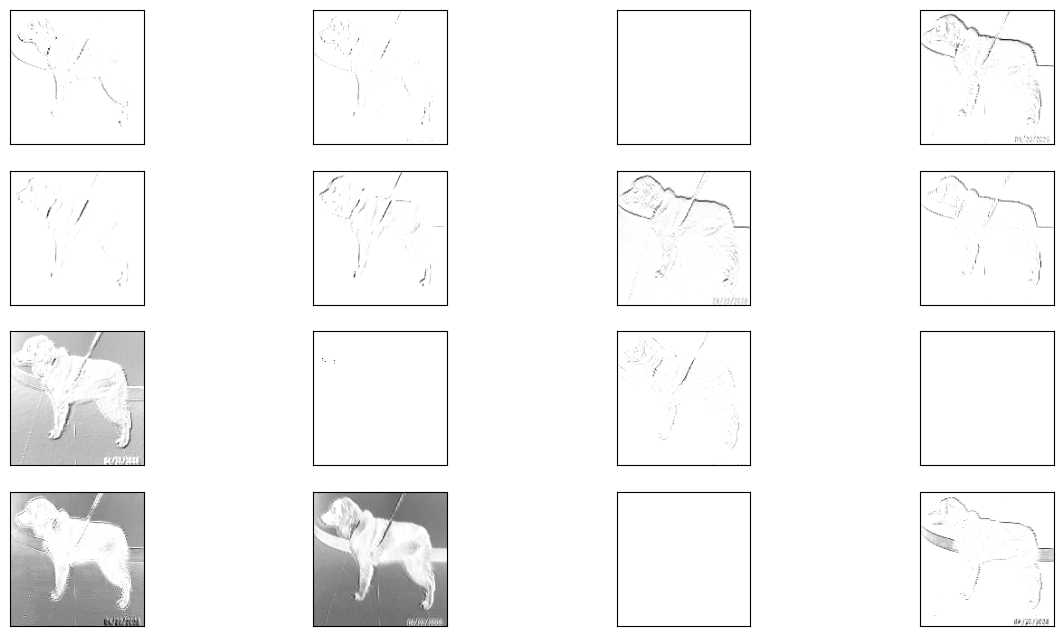

In [ ]:
feature_maps = visualize_feature_map(model, 'conv1', image)

plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0, :, :, i-1], cmap=plt.cm.binary)

### 7. Overfitting evidences

Let's represent the evolution of the error function during the training process. Beyond epoch = 4, overfitting appears.

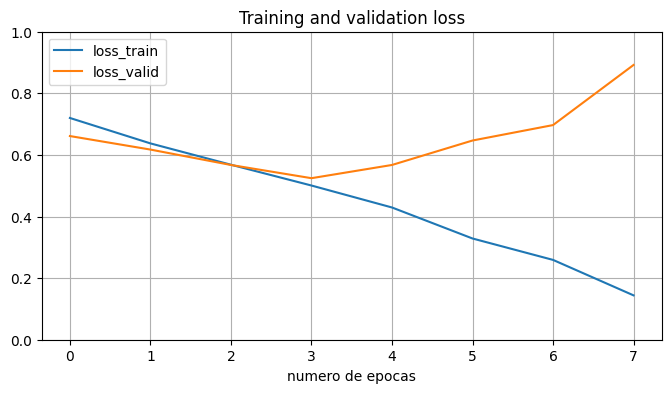

In [ ]:
pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,1)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

### 8. Data augmentation + DropOut

Let's define new generators to perform the augmentation transformations:
* rotations
* shifts
* flips
* zooms

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

Create new flows to the directories:

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


For learning purposes, a new model will be defined using the functional API:

In [ ]:
img_input = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Convolution2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(img_input, output)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['acc'])

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
history_2 = model_2.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      callbacks=[es_callback])

Epoch 1/30
100/100 [==============================] - 19s 162ms/step - loss: 0.7067 - acc: 0.5250 - val_loss: 0.6756 - val_acc: 0.5640
Epoch 2/30
100/100 [==============================] - 16s 160ms/step - loss: 0.6641 - acc: 0.6005 - val_loss: 0.6342 - val_acc: 0.6200
Epoch 3/30
100/100 [==============================] - 16s 161ms/step - loss: 0.6524 - acc: 0.6130 - val_loss: 0.6154 - val_acc: 0.6840
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.6328 - acc: 0.6425 - val_loss: 0.6060 - val_acc: 0.6620
Epoch 5/30
100/100 [==============================] - 16s 158ms/step - loss: 0.6210 - acc: 0.6505 - val_loss: 0.5805 - val_acc: 0.6830
Epoch 6/30
100/100 [==============================] - 16s 161ms/step - loss: 0.6104 - acc: 0.6615 - val_loss: 0.5685 - val_acc: 0.7100
Epoch 7/30
100/100 [==============================] - 16s 158ms/step - loss: 0.6040 - acc: 0.6655 - val_loss: 0.5772 - val_acc: 0.7050
Epoch 8/30
100/100 [==============================] - 1

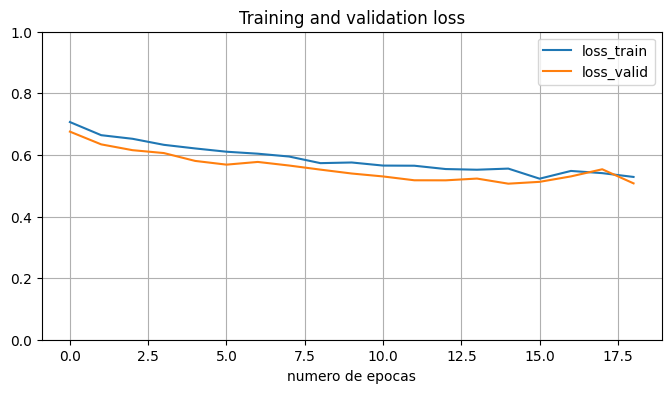

In [ ]:
pd.DataFrame({'loss_train': history_2.history['loss'],
              'loss_valid': history_2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,1)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

Now the training error reduction is accompanied by a reduction of the validation error. Thanks to this effect we are able to delay the overfitting appearance, allowing to train during more epochs.

### 9. Model evaluation

In [ ]:
test_loss, test_acc = model_2.evaluate(validation_generator)

50/50 [==============================] - 3s 51ms/step - loss: 0.5067 - acc: 0.7470
